### MANASA R PES2UG19CS215 D
### MANASI SWAIN PES2UG19CS216 D
### NAMITHA NAYAK PES2UG19CS247 D
### TOSHANI RUNGTA PES2UG19CS433 G

# Helsinki City Bike Network Analysis

In [1]:
import datetime
import calendar
import collections

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community as community_louvain
from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

In [2]:
import os
for dirname, _, filenames in os.walk('Downloads/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Downloads/kaggle/input/.DS_Store
Downloads/kaggle/input/database.csv


In [3]:
dataframe = pd.read_csv("Downloads/kaggle/input/database.csv", low_memory=False)
dataframe.head()

departure               return departure_id    departure_name  \
0  2020-03-23 06:09:44  2020-03-23 06:16:26           86          Kuusitie   
1  2020-03-23 06:11:58  2020-03-23 06:26:31           26        Kamppi (M)   
2  2020-03-23 06:16:29  2020-03-23 06:24:23          268  Porolahden koulu   
3  2020-03-23 06:33:53  2020-03-23 07:14:03          751        Vallipolku   
4  2020-03-23 06:36:09  2020-03-23 07:04:10           62  Länsisatamankatu   

  return_id       return_name  distance (m)  duration (sec.)  \
0     111.0     Esterinportti        1747.0            401.0   
1      10.0       Kasarmitori        1447.0            869.0   
2     254.0       Agnetankuja        1772.0            469.0   
3     106.0   Korppaanmäentie        7456.0           2406.0   
4     121.0  Vilhonvuorenkatu        7120.0           1679.0   

   avg_speed (km/h)  departure_latitude  departure_longitude  return_latitude  \
0          0.261397           60.195245            24.901900        60.197572   
1          0.099908           60.168609            24.930537        60.165017   
2          0.226695           60.195540            25.053581        60.187234   
3          0.185935           60.227827            24.819614        60.203474   
4          0.254437           60.158928            24.909692        60.186463   

   return_longitude  Air temperature (degC)  
0         24.926781                     0.9  
1         24.949473                     0.9  
2         25.036412                     0.9  
3         24.898930                     0.9  
4         24.967872                     0.9

Creating the Graph object

             departure               return departure_id    departure_name  \
0  2020-03-23 06:09:44  2020-03-23 06:16:26           86          Kuusitie   
1  2020-03-23 06:11:58  2020-03-23 06:26:31           26        Kamppi (M)   
2  2020-03-23 06:16:29  2020-03-23 06:24:23          268  Porolahden koulu   
3  2020-03-23 06:33:53  2020-03-23 07:14:03          751        Vallipolku   
4  2020-03-23 06:36:09  2020-03-23 07:04:10           62  Länsisatamankatu   

  return_id       return_name  distance (m)  duration (sec.)  \
0     111.0     Esterinportti        1747.0            401.0   
1      10.0       Kasarmitori        1447.0            869.0   
2     254.0       Agnetankuja        1772.0            469.0   
3     106.0   Korppaanmäentie        7456.0           2406.0   
4     121.0  Vilhonvuorenkatu        7120.0           1679.0   

   avg_speed (km/h)  departure_latitude  departure_longitude  return_latitude  \
0          0.261397           60.195245            24.901900     

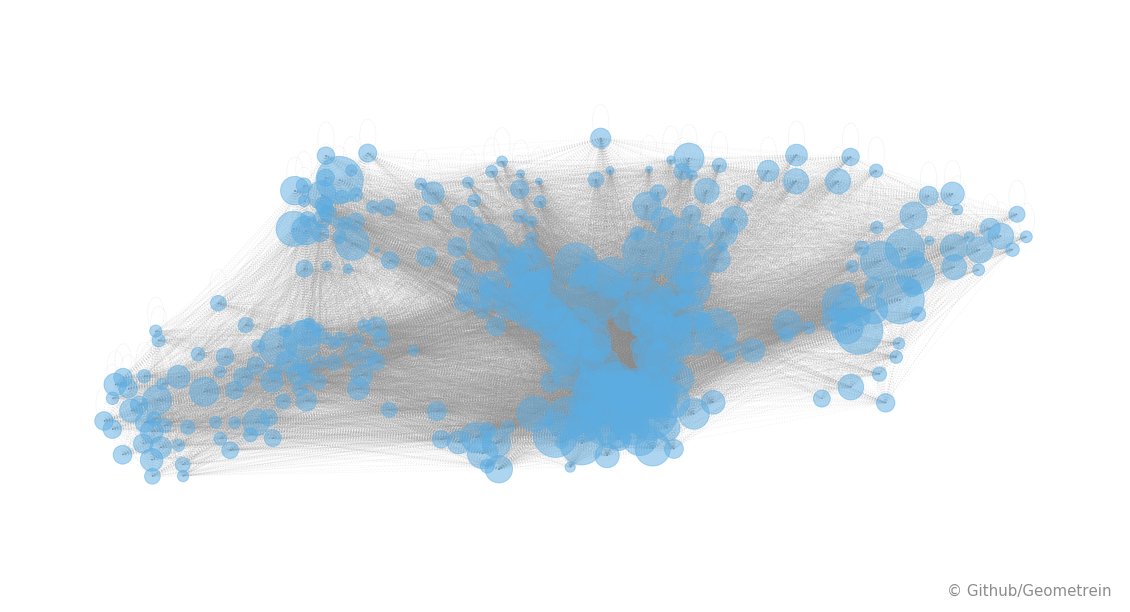

In [8]:
def bikeNetwork(dataframe, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = dataframe.copy()
    print(df.head())
    print("hello 1")
    df['departure'] = pd.to_datetime(df['departure'])

    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
 
   
    
    # Graphs
    G = nx.Graph()
    #G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])
    edge_attr=['distance (m)','duration (sec.)']
    G = nx.from_pandas_edgelist(
      df,
     'departure_name',
     'return_name',
     edge_attr,
    )
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=BLUE, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    ax.axis('off')
    
    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    return G

G = bikeNetwork(dataframe)

In [9]:
def networkStats(G):
    """
    This function prints the basic properties of the City bike network.
    """
    print(nx.info(G))
    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    #print(G.nodes['Kamppi (M)'])

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

networkStats(G)


Graph with 347 nodes and 31784 edges
Network density: 0.5294597791141243
Triadic closure: 0.7366335805953699

Top 5 nodes by degree:

('Haukilahdenkatu', 317)
('Paciuksenkaari', 285)
('Laajalahden aukio', 281)
('Itämerentori', 280)
('Huopalahdentie', 280)

Top 5 nodes by betweenness centrality:

('Haukilahdenkatu', 0.016237342450916282)
('Itämerentori', 0.005948449497953777)
('Paciuksenkaari', 0.00492626443333381)
('Laajalahden aukio', 0.0048554542068282415)
('Huopalahdentie', 0.004507019469877409)


In [28]:
def mapPlot(dataframe, year = 2020):
    """
    This function prints an interactive bubble plot by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df['departure'] = pd.to_datetime(df['departure'])
    df = df[df['departure'].dt.year == year]
    #df = df[:1000]
    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
    #print(df.isna().sum())
    df["name"] = df["departure_name"]
    df = df[["name", "freq"]]
    df = df.drop_duplicates(subset=['name'])
    freq_dict = dict(zip(df.name, df.freq))

    df_stations = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv", index_col=False)
    df_stations = df_stations[df_stations["latitude"]<=60.254011]
    #print(df_stations.head())
    df_stations['freq']= df_stations['name'].map(freq_dict)
    #print(df_stations.head(), df_stations.isna().sum(), len(df_stations))
    df_stations["freq_adj"] = df_stations['freq']/(df_stations['freq'].median()/3)
    df_stations.fillna(1, inplace=True)
    df_stations.dropna(inplace=True)

    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    for index, row in df_stations.iterrows():
        folium.CircleMarker([row['latitude'],row['longitude']],
                        radius=row["freq_adj"],
                        popup=row['freq'],
                        color="#eab544",
                        fill_color="#eab544",
                    ).add_to(hel_map)

    display(hel_map)
    
# function call is commented for performance reasons
mapPlot(dataframe)

# Degree Centrality


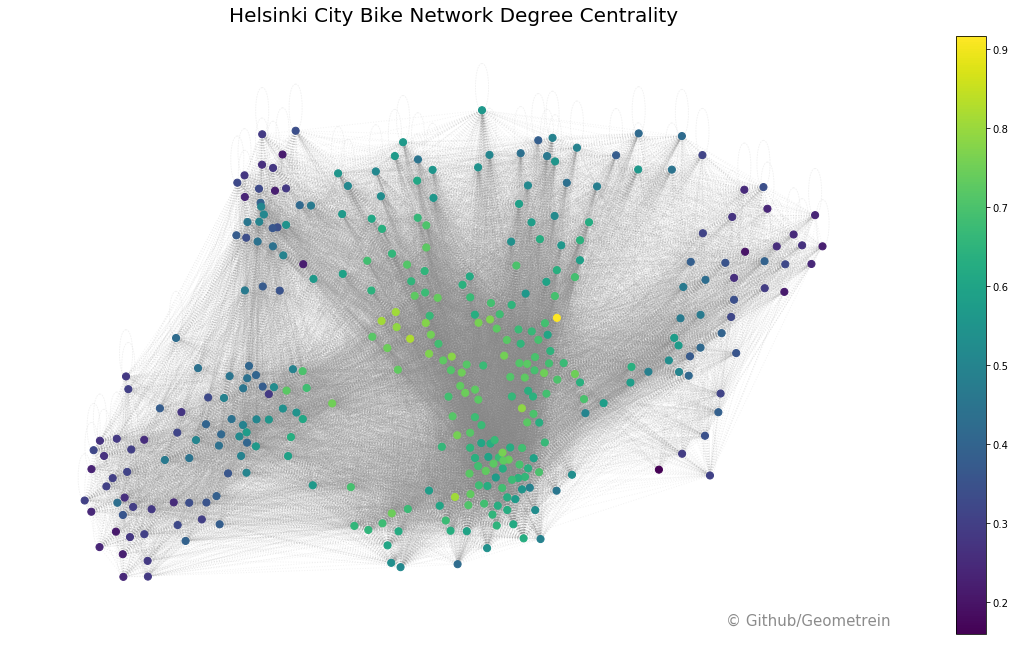

In [13]:
def centralityDegree(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


# function call is commented for performance reasons
centralityDegree(G)

In [14]:
def centralityDegreeInteractive(G):
    """
    This function plots an interactive network with colorcoded node degrees.
    """
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        opacity=0.4,
        line=dict(width=0.5, color='#888', dash='dot'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Blues',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(thickness=15,title='Node Connections',xanchor='left',titleside='right'),
            line_width=1))

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('Number of connections: '+str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    width=800,
                    height=500, 
                    title='Helsinki City Bike Network 2020',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    paper_bgcolor='rgba(255,255,255,0)',
                    plot_bgcolor='rgba(255,255,255,1)',
                    annotations=[ dict(
                        text="Helsinki",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 )],
                    xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                    yaxis=dict(showgrid=True, zeroline=False, showticklabels=True))
                    )

    fig.show()

# function call is commented for performance reasons
#centralityDegreeInteractive(G)

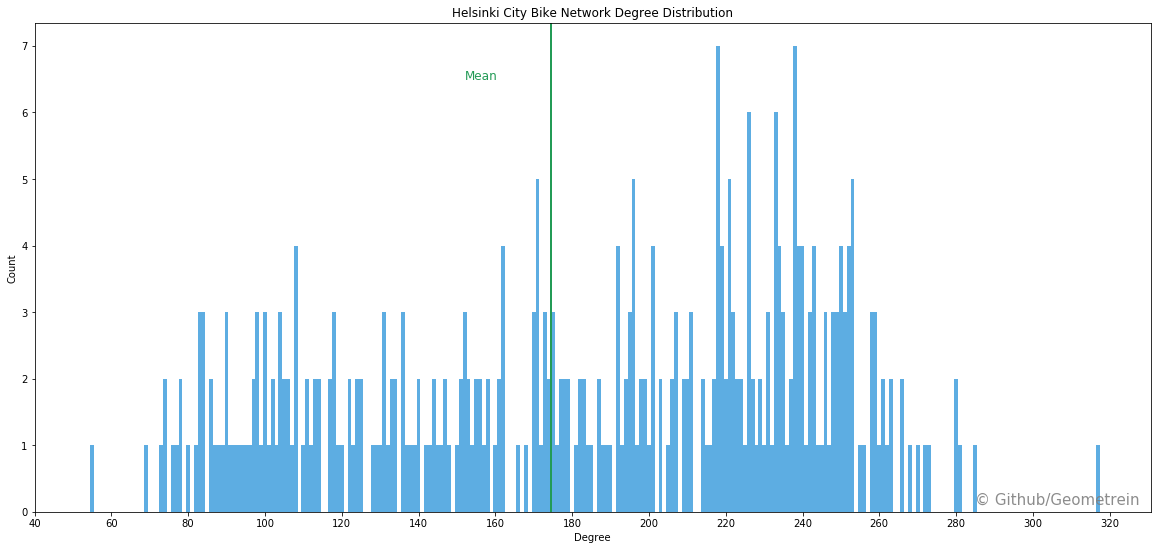

In [15]:
def centralityDegreeDist(G):
    """
    Centrality degree distribution
    """
    # Degree
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    # Figure
    fig, ax = plt.subplots(figsize=(20,9))
    plt.bar(deg, cnt, width=1, color=BLUE)
    plt.axvline(x = sum(deg)/len(deg), color=GREEN, linestyle='-', linewidth=2) # Degree Mean
    #plt.axvline(x = np.median(deg), color="blue", linestyle='-', linewidth=1) # Degree Median

    # Labeling
    plt.title("Helsinki City Bike Network Degree Distribution")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.text(x= 152,y=6.5, s="Mean", color = GREEN, fontsize= 12)
    ax.set_xticks(range(40,340,20))

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
centralityDegreeDist(G)


The average degree of a node in the Helsinki city bike network is 162. This means that a bike station on average is connected to 162 different stations. The stations with the highest centrality degree are:

Haukilahdenkatu: 312 connections

Paciuksenkaari: 272 connections

Huopalahdentie: 267 connections

Laajalahden aukio: 262 connections

Munkkiniemen aukio: 262 connections

Töölöntulli: 260 connections

Tilkanvierto: 259 connections

Paciuksenkatu: 258 connections

Pasilan asema: 258 connections

Esterinportti: 256 connections

The fact that Haukilahdenkatu station is at the top of this list suggests that a large number of citizens from different districts make regular trips to and from this station. This could potentially mean that this station is either next to a large transportation hub or an important point of interest. Quick google search will reveal that it's located across the street from a large educational institution and a work rehabilitation centre. This explains both the regularity of the trips and the inflow of people from different suburban areas.

# Betweenness Centrality


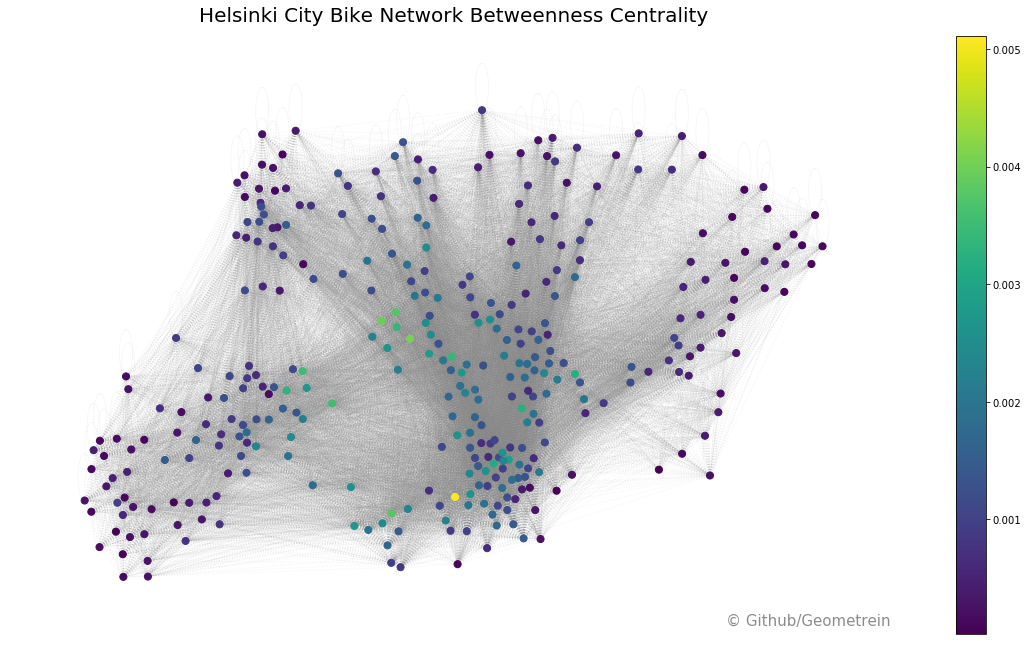

In [16]:
def centralityBetweenness(Graph): 
    """
    This function plots the city bike network betweenes centrality
    """
    
    G = Graph.copy(as_view=False)
    G.remove_node("Haukilahdenkatu")
        
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))
    
   

    betweenness = nx.betweenness_centrality(G)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color)/len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Betweenness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityBetweenness(G)


The node with the highest betweenness centrality represents the Lehtisaarentie station. This is a well-saturated example of geographic constraints affecting the structure of spatial networks. The station is located on the Lehtisaari island that links the Aalto University campus to Munkkiniemi and Helsinki. Due to the specificity of the Helsinki archipelago, traffic flows from one municipality to another are mostly channelled through island-bridge systems that lie in between. This makes both Lehtisaari and Lautasarri islands crucial traffic nodes connecting the municipality of Espoo to Helsinki.

# Closeness Centrality



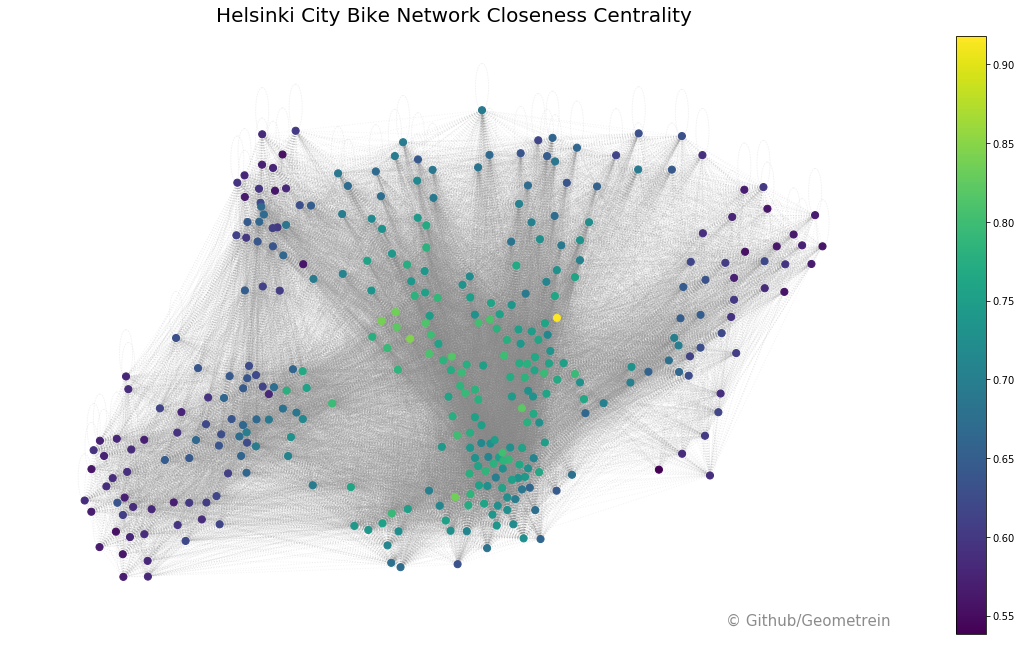

In [17]:
def centralityCloseness(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    closeness = nx.closeness_centrality(G)
    node_color = [closeness[i] for i in closeness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Closeness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityCloseness(G)

As illustrated before a large amount of station is directly connected to Haukilahdenkatu station. This leads to Haukilahdenkatu station having the highest closeness centrality within the network. Other nodes with high closeness centrality are located in the areas of Töölo and Pasila. Closeness centrality might be interesting metrics for network optimization, especially for larger networks. In larger bike-sharing networks users might be motivated to make stops at the intermediary bike stations to avoid extra charges. However, as we have seen in the previous part of this article long trips are not common in Helsinki.

# Eigenvector centrality & PageRank


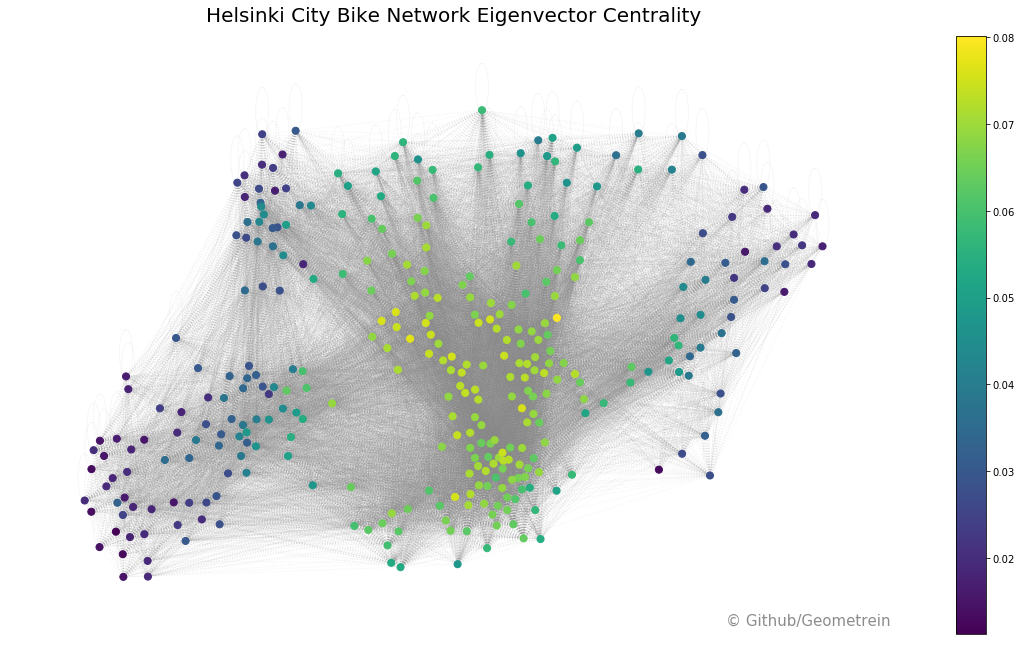

In [18]:
def centralityEigenvector(G):
    """
    This function plots the city bike network Eigenvector centrality
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    eigenvector = nx.eigenvector_centrality(G, max_iter=6000, weight="duration")
    node_color = [eigenvector[i] for i in eigenvector.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Eigenvector Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


# function call is commented for performance reasons
centralityEigenvector(G)

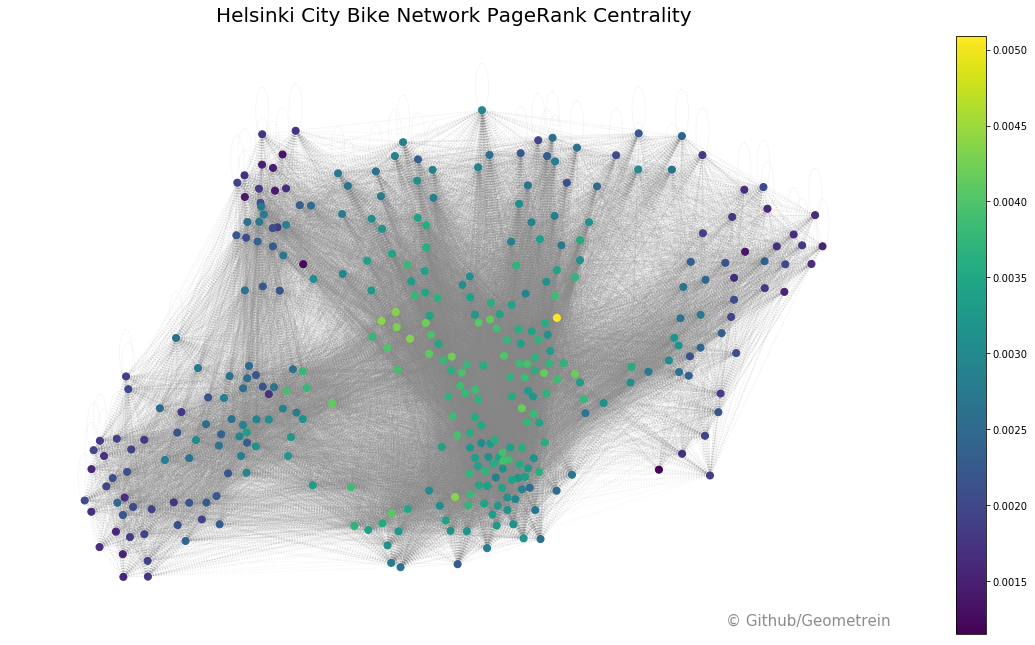

In [23]:
def centralityPageRank(dataframe, year=2020):
    """
    This function plots the city bike network nodes by PageRank
    """

    df = dataframe.copy()
    df['departure'] = pd.to_datetime(df['departure'])
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    
    # Directed Graph
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, source='departure_name', target='return_name', edge_attr=['distance (m)','duration (sec.)'], create_using=nx.DiGraph())

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Phagerank
    phagerank = nx.algorithms.link_analysis.pagerank_alg.pagerank(G, weight="duration")
    node_color = [phagerank[i] for i in phagerank.keys()]

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Color Scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color=node_color, cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network PageRank Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

centralityPageRank(dataframe) 


# Community Detection


### Louvain Method

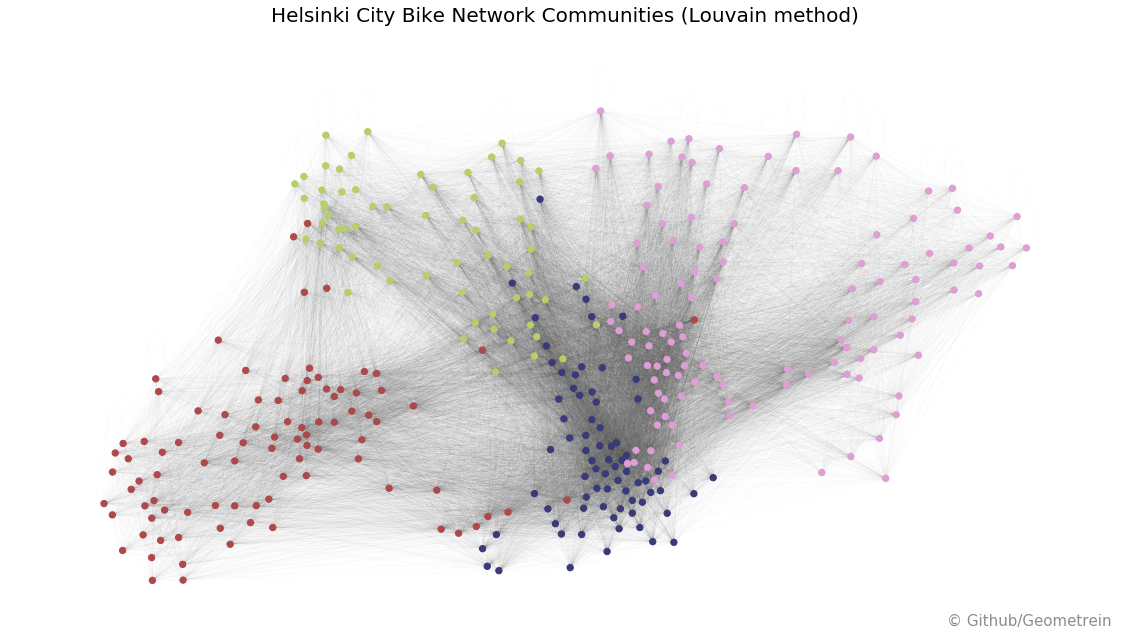

In [26]:
def communityLouvain(G):
    """
    This function applies the Louvain method for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Louvain method
    partition = community_louvain.best_partition(G, resolution=0.95, random_state=1)

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.015)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Communities (Louvain method)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
communityLouvain(G)

This means that bike usage inside these four communities is higher than the bike usage between these communities. Nodes with high betweenness centrality are usually the places where the communities might be divided into modules. If we return to our betweenness centrality graph this relationship will become even more evident. Boundaries of the communities pass roughly through the nodes with high betweenness centrality. 

### Fluid Communities Method


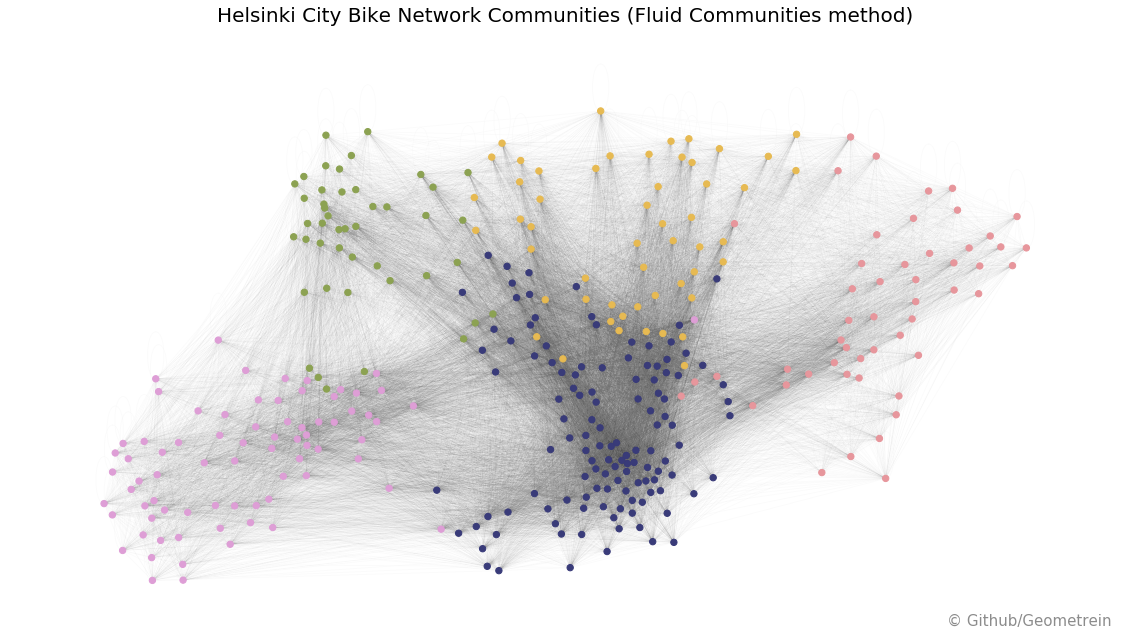

In [27]:
def communityFluid(G):
    """
    This function applies the Fluid Communities method for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Fluid method
    communities = nx.algorithms.community.asyn_fluid.asyn_fluidc(G, k=5, max_iter=10000, seed=1)
    
    # Assigning each node to its cluster
    partition = {}
    for idx, val in enumerate(communities):
        for k in val:
            partition[k] = idx

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.015)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Communities (Fluid Communities method)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
communityFluid(G)

We can see that the Fluid community detection method confirms the communities identified with the Louvain method and identifies one additional community. 